# Let's apply some transformations to our dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
%matplotlib inline
sys.path.insert(0, os.path.abspath('../src'))
import functions as fn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
import pickle

In [2]:
bank_f = pd.read_csv('../Data/raw/bank-full.csv', sep = ';')
bank_f

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [3]:
numerical_df, categorical_df = fn.num_cat_splitter(bank_f)

As we saw in *exploratory_data_analysis.ipynb* our dataset had a lot of outliers:

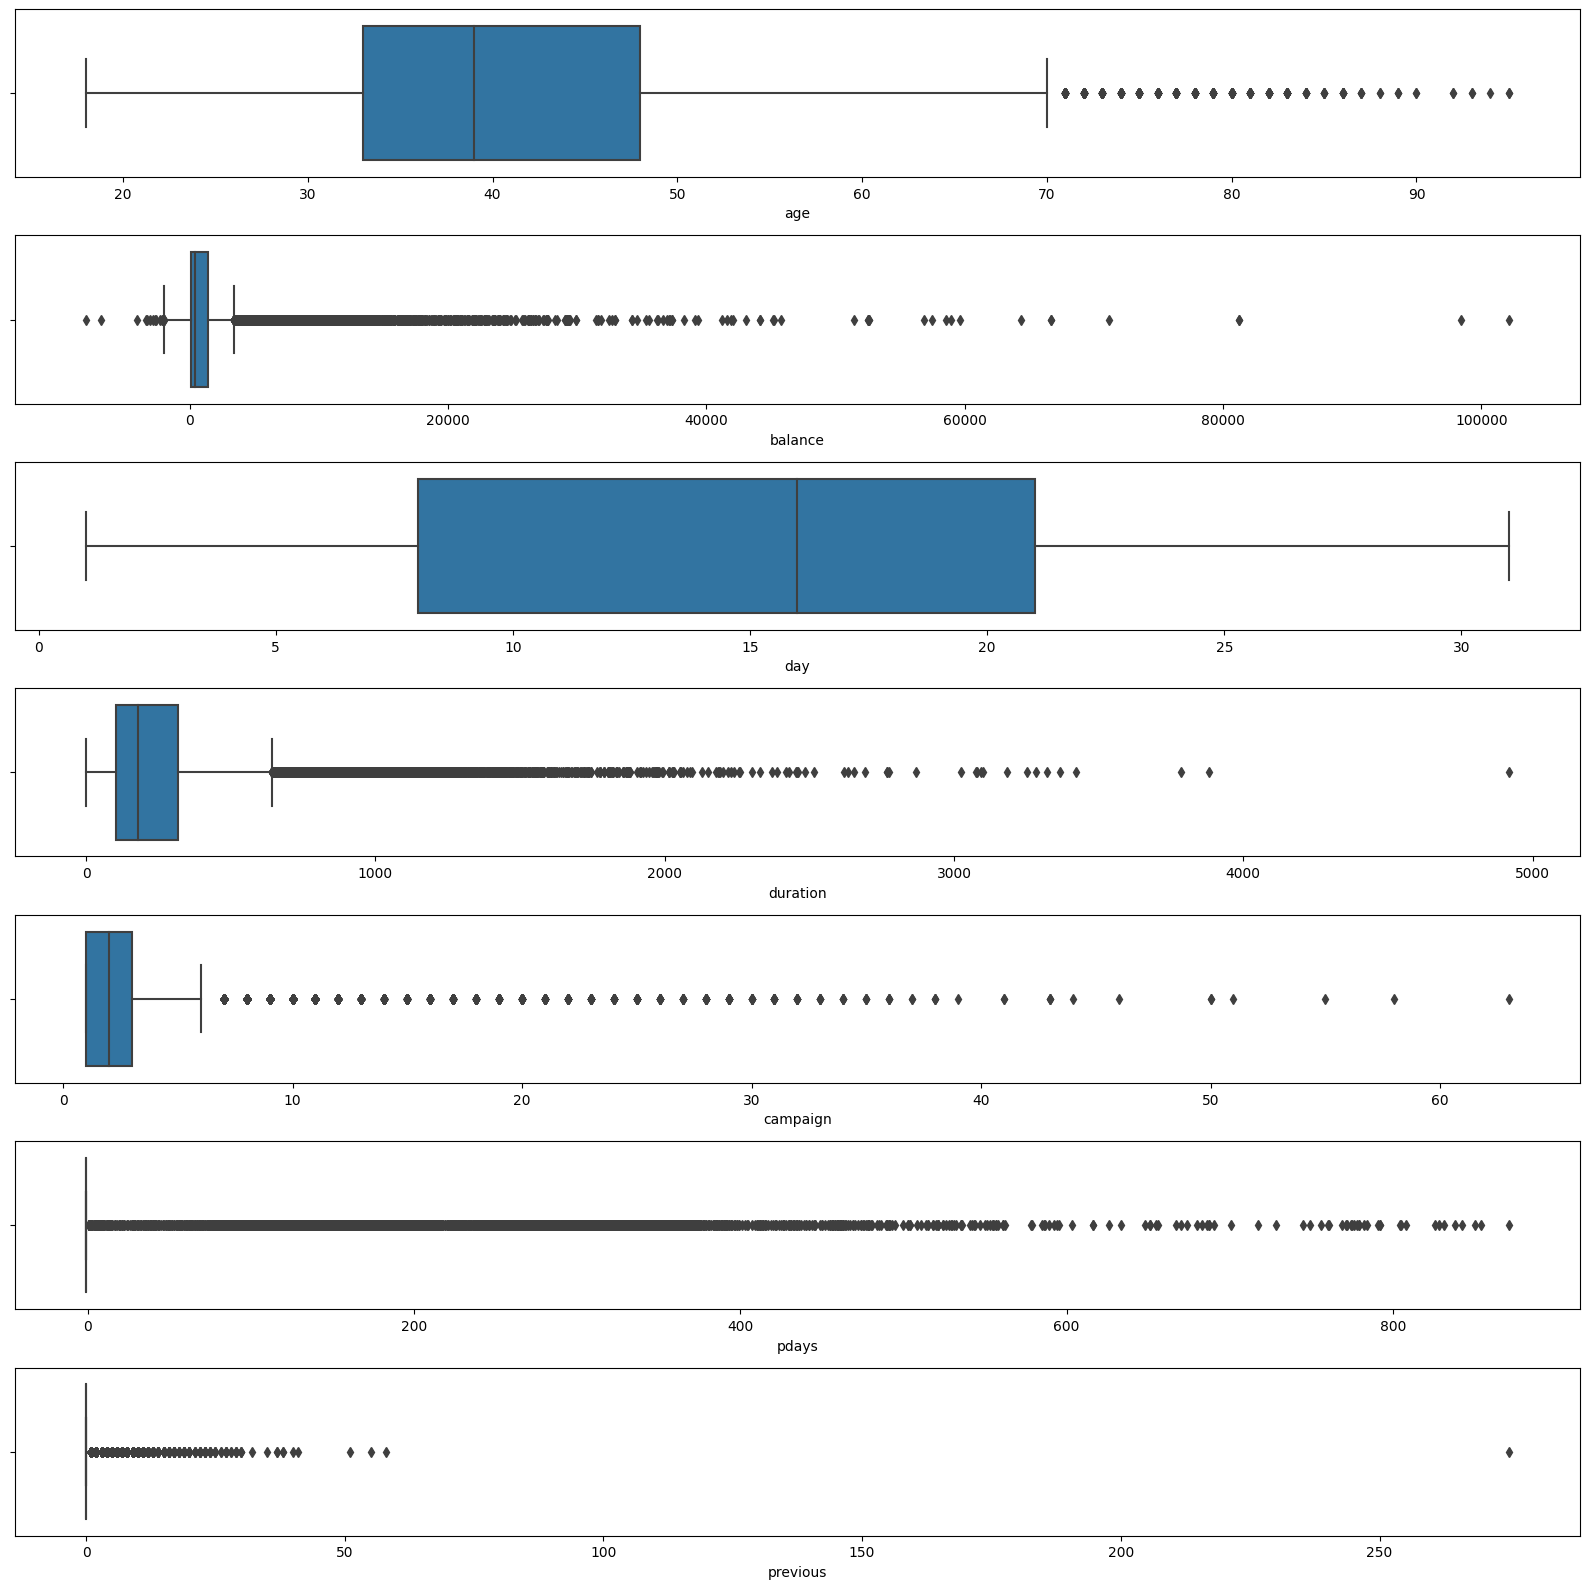

In [4]:
fn.box_generator(numerical_df, save ='No')

Therefore we are going to remove outliers taking into consideration all the values which are between 3 times smaller or bigger the standard deviation of the mean:

In [5]:
numerical_0out = fn.outlier_remover(numerical_df)

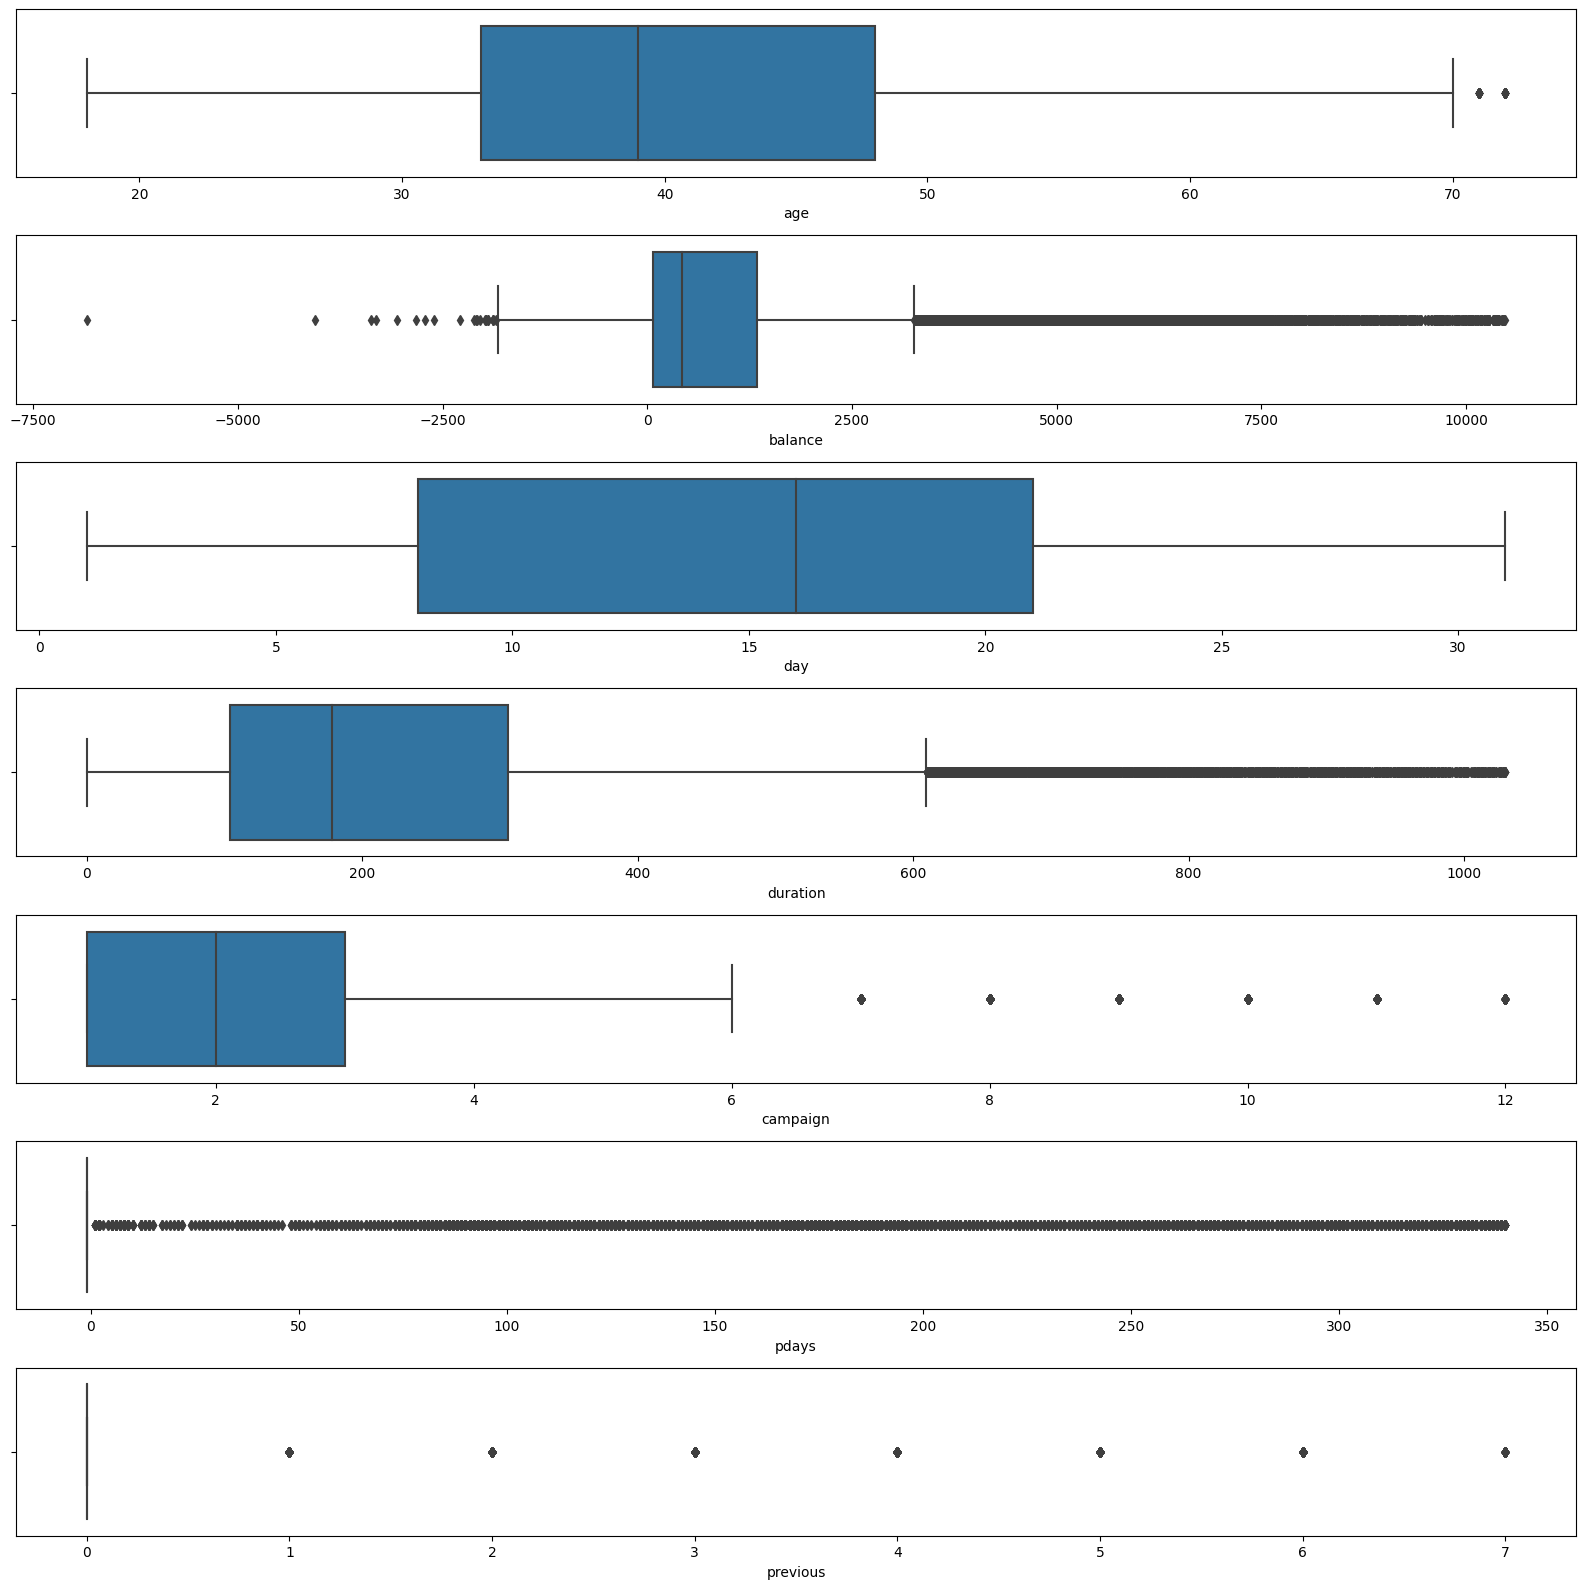

In [6]:
fn.box_generator(numerical_0out, name ='../Slides/without_outliers_plot.png')

In [7]:
categorical_df.shape

(45211, 10)

In [8]:
numerical_0out.shape

(40209, 7)

Now our data looks much better, however, the numerical columns are heavily skewed:

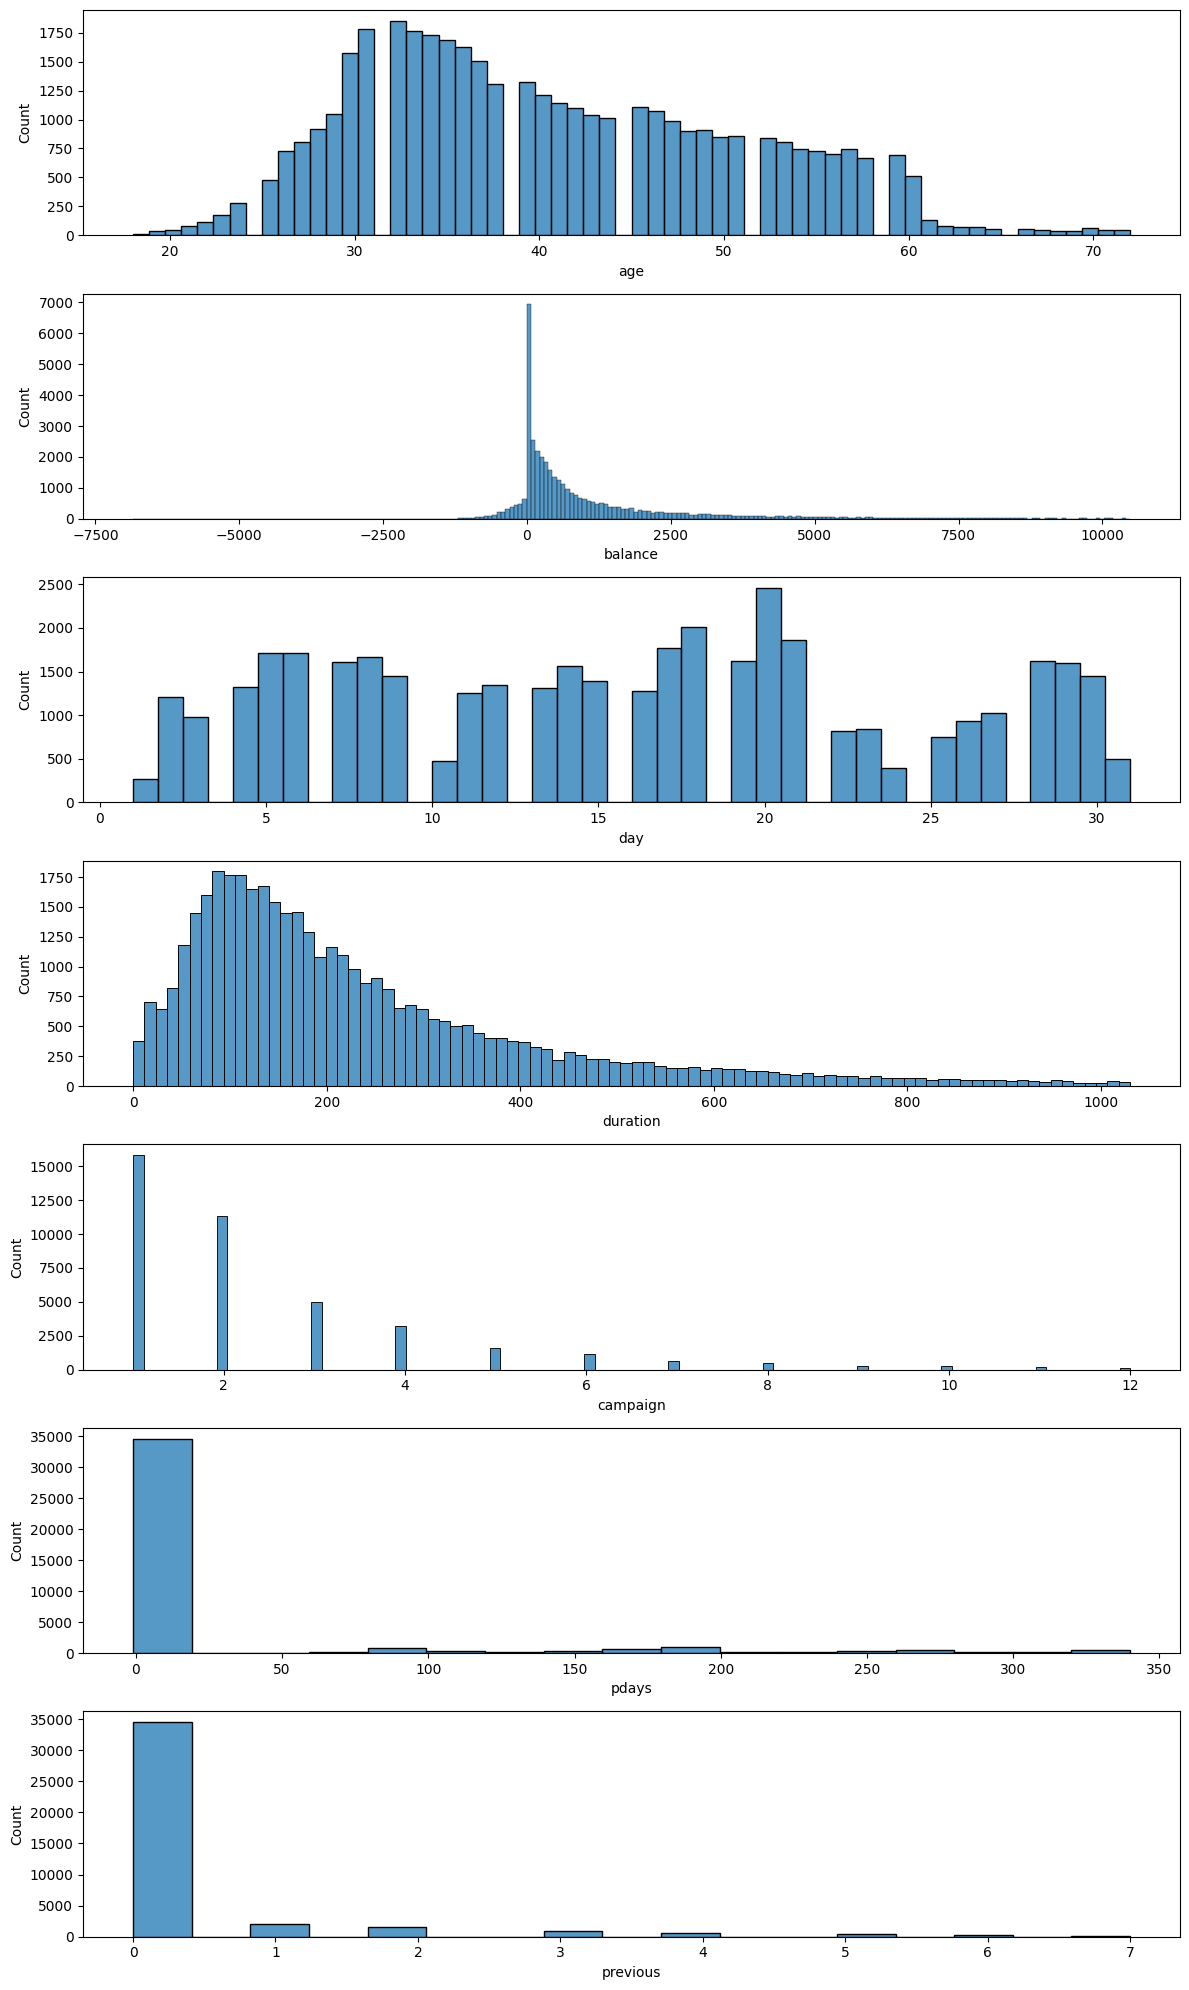

In [9]:
fn.hist_generator(numerical_0out, save='No')

Some are better than before, nevertheless we can apply a PowerTransformer in order to make distributions more Gaussian-like:

In [10]:
bank_0out = pd.concat([categorical_df, numerical_0out], axis=1)
bank_0out = bank_0out.dropna().reset_index(drop=True)
bank_0out

,job,marital,education,default,housing,loan,contact,month,poutcome,y,age,balance,day,duration,campaign,pdays,previous
0,management,married,tertiary,no,yes,no,unknown,may,unknown,no,58.0,2143.0,5.0,261.0,1.0,-1.0,0.0
1,technician,single,secondary,no,yes,no,unknown,may,unknown,no,44.0,29.0,5.0,151.0,1.0,-1.0,0.0
2,entrepreneur,married,secondary,no,yes,yes,unknown,may,unknown,no,33.0,2.0,5.0,76.0,1.0,-1.0,0.0
3,blue-collar,married,unknown,no,yes,no,unknown,may,unknown,no,47.0,1506.0,5.0,92.0,1.0,-1.0,0.0
4,unknown,single,unknown,no,no,no,unknown,may,unknown,no,33.0,1.0,5.0,198.0,1.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40204,self-employed,married,unknown,no,no,no,cellular,jun,unknown,yes,23.0,113.0,17.0,266.0,1.0,-1.0,0.0
40205,technician,married,secondary,no,yes,no,cellular,jun,unknown,yes,25.0,505.0,17.0,386.0,2.0,-1.0,0.0
40206,self-employed,single,tertiary,no,yes,no,cellular,jun,unknown,no,51.0,825.0,17.0,977.0,3.0,-1.0,0.0
40207,blue-collar,married,primary,no,no,no,cellular,jun,unknown,yes,71.0,1729.0,17.0,456.0,2.0,-1.0,0.0


In order to perform our predictions, we should make the X-Y split:

In [11]:
y = bank_0out['y']
X = bank_0out.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

And we have to split again numericals and categoricals in order to fit our transformations in the train set

In [12]:
X_train_num, X_train_cat = fn.num_cat_splitter(X_train)
X_test_num, X_test_cat = fn.num_cat_splitter(X_test)

In [13]:
transformer = PowerTransformer().fit(X_train_num)

X_train_num_trans = transformer.transform(X_train_num)
X_test_num_trans = transformer.transform(X_test_num)

with open('../Transformers/power_transformer.pkl', 'wb') as file:
    pickle.dump(transformer, file)

Now that the distribution should be more Gaussian-like, we have to apply Min Max Scaler in order to be understandable our model once we concatenate the numerical columns transformered with categoricals encoded.

In [14]:
scaler = MinMaxScaler().fit(X_train_num_trans)

X_train_num_scal = transformer.transform(X_train_num_trans)
X_test_num_scal = transformer.transform(X_test_num_trans)

X_train_scaled = pd.DataFrame(X_train_num_scal, columns=X_train_num.columns)
X_test_scaled = pd.DataFrame(X_test_num_scal, columns=X_test_num.columns)

with open('../Scalers/minmax_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

C:\Users\Pablo\Ironhack\Week_5\Mid_bootcamp_project\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
C:\Users\Pablo\Ironhack\Week_5\Mid_bootcamp_project\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


In [15]:
encoder = OneHotEncoder(drop='first').fit(X_train_cat)

X_train_cat_np = encoder.transform(X_train_cat).toarray()
X_test_cat_np = encoder.transform(X_test_cat).toarray()

X_train_cat_encoded = pd.DataFrame(X_train_cat_np, columns=encoder.get_feature_names_out())
X_test_cat_encoded = pd.DataFrame(X_test_cat_np, columns=encoder.get_feature_names_out())

with open('../Encoders/onehot_encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)

In [16]:
X_train_transformed = pd.concat([X_train_scaled, X_train_cat_encoded], axis=1)
X_train_transformed.head()
X_train_transformed_df = X_train_transformed.to_csv('../Data/cleaned/X_train_transformed.csv', index=False)

In [17]:
X_test_transformed = pd.concat([X_test_scaled, X_test_cat_encoded], axis=1)
X_test_transformed.head()
X_test_transformed_df = X_test_transformed.to_csv('../Data/cleaned/X_test_transformed.csv', index=False)

Furthermore, as we saw the target column I want to predict is heavily imbalanced, so I have decided to oversample the *y* because if we downsample it a lot of data will be lost and the model wouldn't predict well the people who doesn't subscribe a term deposit.  

In [18]:
ros = RandomOverSampler(random_state=23)
X_train_over, y_train_over = ros.fit_resample(X_train_transformed, y_train)

xy_trained_oversampled = pd.concat([X_train_over,y_train_over],axis=1)
xy_trained_oversampled_df = xy_trained_oversampled.to_csv('../Data/cleaned/xy_trained_oversampled.csv', index=False)

display(xy_trained_oversampled.head())
print('Resampled dataset shape %s' % Counter(y_train_over))
print(y_train_over.value_counts())

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,poutcome_other,poutcome_success,poutcome_unknown,y
0,-23.917584,-0.569158,-2.346594,-3.873375,-3.901809,0.947828,-30.881285,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,yes
1,-12.145779,-0.568959,-2.455018,-4.176878,-0.459455,0.947828,-30.881285,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,no
2,-13.419410,-0.567612,-2.076830,-4.311421,-3.901809,2.108973,2.483081,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,no
3,-16.684624,-0.569125,-2.198535,-3.558794,-0.819603,0.947828,-30.881285,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,no
4,-17.296765,-0.570267,-2.628372,-3.743962,0.170985,0.947828,-30.881285,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,no


Resampled dataset shape Counter({'yes': 29811, 'no': 29811})
yes    29811
no     29811
Name: y, dtype: int64


In [19]:
lr = LogisticRegression(random_state=23, solver='lbfgs', max_iter=1000).fit(X_train_over, y_train_over)

y_train_pred = lr.predict(X_train_over)
y_test_pred  = lr.predict(X_test_transformed)

with open('../Models/log_reg_oversampled.pkl', 'wb') as file:
    pickle.dump(lr, file)

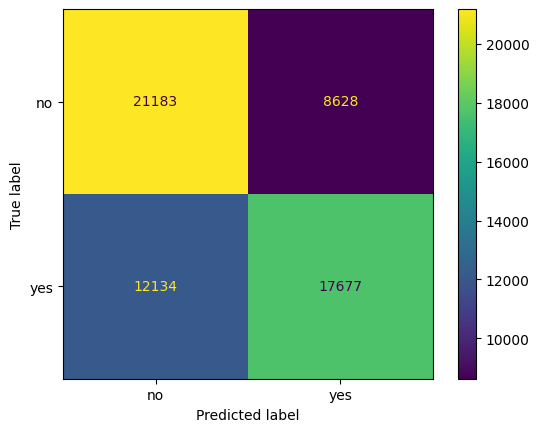

In [20]:
cm_train_oversampled = confusion_matrix(y_train_over, y_train_pred)

disp_train_over = ConfusionMatrixDisplay(cm_train_oversampled, display_labels=lr.classes_)
disp_train_over.plot()
plt.savefig('../Slides/conf_matrix_train_oversampled.png', dpi=300, transparent=True)
plt.show()

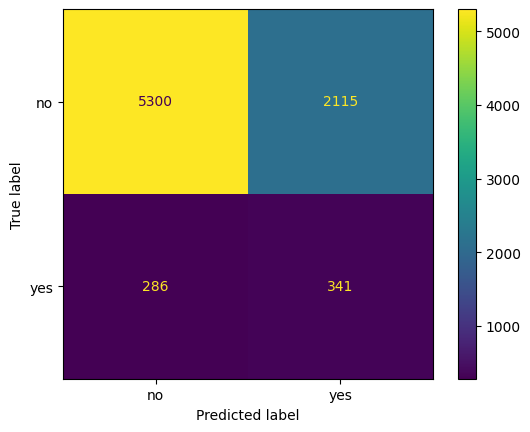

In [21]:
cm_test_oversampled = confusion_matrix(y_test, y_test_pred)

disp_test_over = ConfusionMatrixDisplay(cm_test_oversampled, display_labels=lr.classes_)
disp_test_over.plot()
plt.savefig('../Slides/conf_matrix_test_oversampled.png', dpi=300, transparent=True)
plt.show()

In [22]:
print("The accuracy in the TRAIN set is: {:.3f}".format(accuracy_score(y_train_over, y_train_pred)))
print("The accuracy in the TEST  set is: {:.3f}".format(accuracy_score(y_test, y_test_pred)))
print(classification_report(y_test, y_test_pred, target_names=['No','Yes']))
print(cohen_kappa_score(y_train_over, y_train_pred))

The accuracy in the TRAIN set is: 0.652
The accuracy in the TEST  set is: 0.701
              precision    recall  f1-score   support

          no       0.95      0.71      0.82      7415
         yes       0.14      0.54      0.22       627

    accuracy                           0.70      8042
   macro avg       0.54      0.63      0.52      8042
weighted avg       0.89      0.70      0.77      8042

0.3035456710610177


In [23]:
coef_list_abs = list(zip(np.abs(lr.coef_[0]).tolist(),list(X_train.columns)))
coef_list_abs.sort(reverse=True)
print(coef_list_abs)
coef_list = list(zip(list(X_train.columns),lr.coef_[0].tolist()))
coef_list

[(0.4006447256922371, 'age'), (0.39300337621176057, 'day'), (0.3164867372480877, 'loan'), (0.21774121511809874, 'pdays'), (0.12375769697410136, 'duration'), (0.1138622463698609, 'marital'), (0.07146557769219615, 'balance'), (0.052019699535227705, 'poutcome'), (0.049264546687053996, 'education'), (0.022237538989299938, 'default'), (0.010685910699279428, 'campaign'), (0.007073704627990158, 'contact'), (0.0057345858824173765, 'job'), (0.0014945880592713886, 'month'), (0.0002670016004349014, 'previous'), (6.777833482835371e-05, 'housing')]


[('job', -0.0057345858824173765),
 ('marital', -0.1138622463698609),
 ('education', 0.049264546687053996),
 ('default', 0.022237538989299938),
 ('housing', -6.777833482835371e-05),
 ('loan', 0.3164867372480877),
 ('contact', -0.007073704627990158),
 ('month', -0.0014945880592713886),
 ('poutcome', -0.052019699535227705),
 ('age', -0.4006447256922371),
 ('balance', -0.07146557769219615),
 ('day', 0.39300337621176057),
 ('duration', -0.12375769697410136),
 ('campaign', -0.010685910699279428),
 ('pdays', 0.21774121511809874),
 ('previous', -0.0002670016004349014)]

The model is not good, so let's try with SMOTE

In [24]:
sm = SMOTE(random_state=23)
X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train_transformed,y_train)

xy_trained_SMOTED = pd.concat([X_train_SMOTE,y_train_SMOTE],axis=1)
xy_trained_SMOTED_df = xy_trained_SMOTED.to_csv('../Data/cleaned/xy_trained_SMOTED.csv', index=False)

In [25]:
lr2 = LogisticRegression(max_iter=1000, random_state=23).fit(X_train_SMOTE, y_train_SMOTE)

y_train_pred2 = lr2.predict(X_train_SMOTE)
y_test_pred2 = lr2.predict(X_test_transformed)

with open('../Models/log_reg_SMOTED.pkl', 'wb') as file:
    pickle.dump(lr2, file)

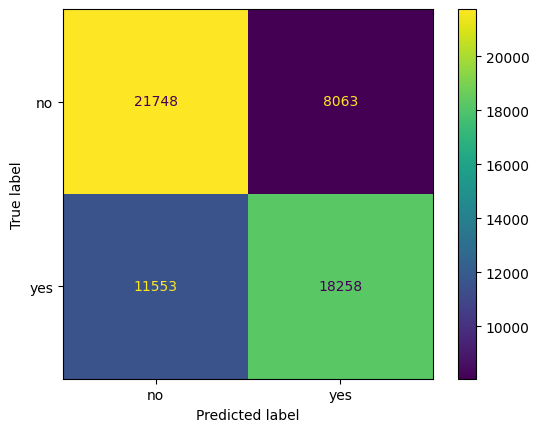

In [26]:
cm_train_SMOTED = confusion_matrix(y_train_SMOTE, y_train_pred2)
disp_train_SMOTED = ConfusionMatrixDisplay(cm_train_SMOTED, display_labels=lr2.classes_)
disp_train_SMOTED.plot()
plt.savefig('../Slides/conf_matrix_train_SMOTED.png', dpi=300, transparent=True)
plt.show()

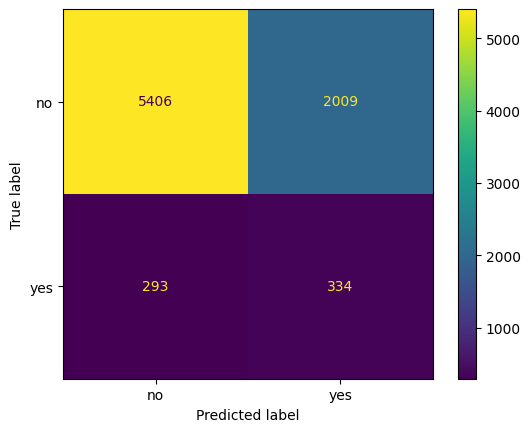

In [27]:
cm_test_SMOTED = confusion_matrix(y_test, y_test_pred2)
disp_test_SMOTED = ConfusionMatrixDisplay(cm_test_SMOTED, display_labels=lr2.classes_)
disp_test_SMOTED.plot()
plt.savefig('../Slides/conf_matrix_test_SMOTED.png', dpi=300, transparent=True)
plt.show()

In [28]:
print("The accuracy in the TRAIN set is: {:.3f}".format(accuracy_score(y_train_SMOTE, y_train_pred2)))
print("The accuracy in the TEST  set is: {:.3f}".format(accuracy_score(y_test, y_test_pred2)))
print(classification_report(y_test, y_test_pred2, target_names=['No','Yes']))
print(cohen_kappa_score(y_train_SMOTE, y_train_pred2))

The accuracy in the TRAIN set is: 0.671
The accuracy in the TEST  set is: 0.714
              precision    recall  f1-score   support

           A       0.95      0.73      0.82      7415
           B       0.14      0.53      0.22       627

    accuracy                           0.71      8042
   macro avg       0.55      0.63      0.52      8042
weighted avg       0.89      0.71      0.78      8042

0.341987856831371


The model seems to be a bit better, but still it's not good at all. Let's try to use KNN Classifier instead of Logistic Regression.

In [31]:
knn_models_oversampled = {}
weights = ["uniform","distance"]
p_values = [1,2,3]
scores_oversampled = {}
for k in range(2,15):
    for weight in weights:
        for value in p_values:
            model_oversampled = KNeighborsClassifier(n_neighbors=k,weights=weight,p=value).fit(X_train_over, y_train_over)
            print("Training the K-NN model with {} neighbours with weights {} and p set to {}...".format(k,weight,value))
            knn_models_oversampled[str(k)+"_"+weight+"_"+str(value)] = model_oversampled
            scores_oversampled[str(k)+"_"+weight+"_"+str(value)] = model_oversampled.score(X_test_transformed, y_test)
            print()

Training the k-NN model with 2 neighbours with weights uniform and p set to 1...

Training the k-NN model with 2 neighbours with weights uniform and p set to 2...

Training the k-NN model with 2 neighbours with weights uniform and p set to 3...

Training the k-NN model with 2 neighbours with weights distance and p set to 1...

Training the k-NN model with 2 neighbours with weights distance and p set to 2...

Training the k-NN model with 2 neighbours with weights distance and p set to 3...

Training the k-NN model with 3 neighbours with weights uniform and p set to 1...

Training the k-NN model with 3 neighbours with weights uniform and p set to 2...

Training the k-NN model with 3 neighbours with weights uniform and p set to 3...

Training the k-NN model with 3 neighbours with weights distance and p set to 1...

Training the k-NN model with 3 neighbours with weights distance and p set to 2...

Training the k-NN model with 3 neighbours with weights distance and p set to 3...

Training t

In [32]:
knn_models_oversampled

{'2_uniform_1': KNeighborsClassifier(n_neighbors=2, p=1),
 '2_uniform_2': KNeighborsClassifier(n_neighbors=2),
 '2_uniform_3': KNeighborsClassifier(n_neighbors=2, p=3),
 '2_distance_1': KNeighborsClassifier(n_neighbors=2, p=1, weights='distance'),
 '2_distance_2': KNeighborsClassifier(n_neighbors=2, weights='distance'),
 '2_distance_3': KNeighborsClassifier(n_neighbors=2, p=3, weights='distance'),
 '3_uniform_1': KNeighborsClassifier(n_neighbors=3, p=1),
 '3_uniform_2': KNeighborsClassifier(n_neighbors=3),
 '3_uniform_3': KNeighborsClassifier(n_neighbors=3, p=3),
 '3_distance_1': KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'),
 '3_distance_2': KNeighborsClassifier(n_neighbors=3, weights='distance'),
 '3_distance_3': KNeighborsClassifier(n_neighbors=3, p=3, weights='distance'),
 '4_uniform_1': KNeighborsClassifier(n_neighbors=4, p=1),
 '4_uniform_2': KNeighborsClassifier(n_neighbors=4),
 '4_uniform_3': KNeighborsClassifier(n_neighbors=4, p=3),
 '4_distance_1': KNeighborsCl

In [33]:
knn_scores_oversampled = {}

for key in knn_models_oversampled.keys():
    knn_scores_oversampled[key] = knn_models_oversampled[key].score(X_test_transformed, y_test)

knn_scores_oversampled

{'2_uniform_1': 0.8709276299428003,
 '2_uniform_2': 0.8711763242974384,
 '2_uniform_3': 0.8699328525242477,
 '2_distance_1': 0.8709276299428003,
 '2_distance_2': 0.8711763242974384,
 '2_distance_3': 0.8699328525242477,
 '3_uniform_1': 0.8187018154687888,
 '3_uniform_2': 0.8203183287739368,
 '3_uniform_3': 0.820691370305894,
 '3_distance_1': 0.8241730912708282,
 '3_distance_2': 0.8246704799801045,
 '3_distance_3': 0.825540910221338,
 '4_uniform_1': 0.8187018154687888,
 '4_uniform_2': 0.8203183287739368,
 '4_uniform_3': 0.820691370305894,
 '4_distance_1': 0.8215618005471276,
 '4_distance_2': 0.8225565779656802,
 '4_distance_3': 0.8220591892564039,
 '5_uniform_1': 0.7764237751803034,
 '5_uniform_2': 0.7780402884854514,
 '5_uniform_3': 0.7750559562297936,
 '5_distance_1': 0.7879880626709773,
 '5_distance_2': 0.7862472021885103,
 '5_distance_3': 0.7835115642874907,
 '6_uniform_1': 0.7769211638895797,
 '6_uniform_2': 0.7784133300174086,
 '6_uniform_3': 0.7754289977617508,
 '6_distance_1': 0.

In [34]:
values = []
for key in list(scores_oversampled.keys()):
    values.append((scores_oversampled[key], int(key.split("_")[0]), key.split("_")[1], key.split("_")[2]))

knn_models_oversampled_df = pd.DataFrame(values, columns=["score","K","weight","p"])
knn_models_oversampled_df

,score,K,weight,p
0,0.870928,2,uniform,1
1,0.871176,2,uniform,2
2,0.869933,2,uniform,3
3,0.870928,2,distance,1
4,0.871176,2,distance,2
...,...,...,...,...
73,0.630689,14,uniform,2
74,0.628699,14,uniform,3
75,0.655310,14,distance,1
76,0.645486,14,distance,2


In [35]:
knn_models_oversampled_df_csv = knn_models_oversampled_df.to_csv('../Data/cleaned/knn_models_oversampled.csv', index=False)

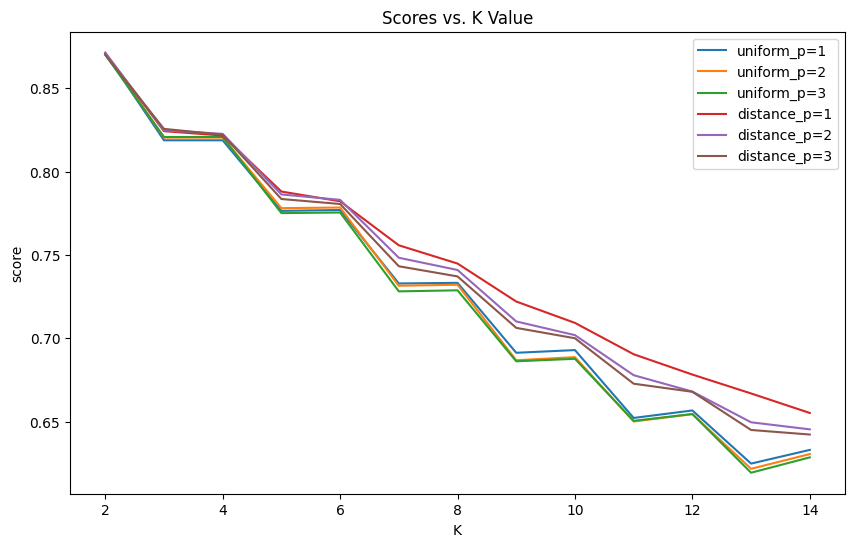

In [38]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=knn_models_oversampled_df[(knn_models_oversampled_df['weight']=="uniform") &
                                            (knn_models_oversampled_df['p']=="1")],  x="K",y="score", 
                                             markers="x",label="uniform_p=1" ,ax = ax)

sns.lineplot(data=knn_models_oversampled_df[(knn_models_oversampled_df['weight']=="uniform") & 
                                            (knn_models_oversampled_df['p']=="2") ], x="K",y="score",
                                             markers="o", label="uniform_p=2" ,ax = ax)

sns.lineplot(data=knn_models_oversampled_df[(knn_models_oversampled_df['weight']=="uniform") & 
                                            (knn_models_oversampled_df['p']=="3") ], x="K",y="score",
                                             markers="o", label="uniform_p=3",ax = ax)

sns.lineplot(data=knn_models_oversampled_df[(knn_models_oversampled_df['weight']=="distance") & 
                                            (knn_models_oversampled_df['p']=="1")],  x="K",y="score", 
                                             markers="x", label="distance_p=1" ,ax = ax)

sns.lineplot(data=knn_models_oversampled_df[(knn_models_oversampled_df['weight']=="distance") & 
                                            (knn_models_oversampled_df['p']=="2") ], x="K",y="score",
                                             markers="o", label="distance_p=2",ax = ax)

sns.lineplot(data=knn_models_oversampled_df[(knn_models_oversampled_df['weight']=="distance") & 
                                            (knn_models_oversampled_df['p']=="3") ], x="K",y="score",
                                             markers="o", label="distance_p=3",ax = ax)
plt.title('Scores vs. K Value')
plt.savefig('../Slides/scores_vs_kvalue_oversampled.png', dpi=300, transparent=True)
plt.legend()
plt.show()

In [39]:
topmodel_knn_over = KNeighborsClassifier(n_neighbors=2, weights = "distance").fit(X_train_over, y_train_over)
topscore_over = topmodel_knn_over.score(X_test_transformed, y_test)

print("The score for the K-NN model with 2 neighbours, weighted by distance is {:.3f}".format(topscore_over))

with open('../Models/KNN_class_oversampled.pkl', 'wb') as file:
    pickle.dump(topmodel_knn_over, file)

The score for the K-NN model with 2 neighbours, weighted by distance is 0.871


In [41]:
y_train_pred_knn_over = topmodel_knn_over.predict(X_train_over)
y_test_pred_knn_over  = topmodel_knn_over.predict(X_test_transformed)

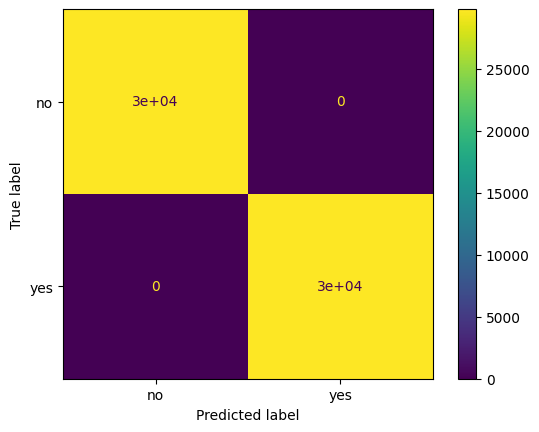

In [42]:
cm_train_oversampled_knn = confusion_matrix(y_train_over, y_train_pred_knn_over)

disp_train_over_knn = ConfusionMatrixDisplay(cm_train_oversampled_knn, display_labels=topmodel_knn_over.classes_)
disp_train_over_knn.plot()
plt.savefig('../Slides/conf_matrix_train_oversampled_knn.png', dpi=300, transparent=True)
plt.show()

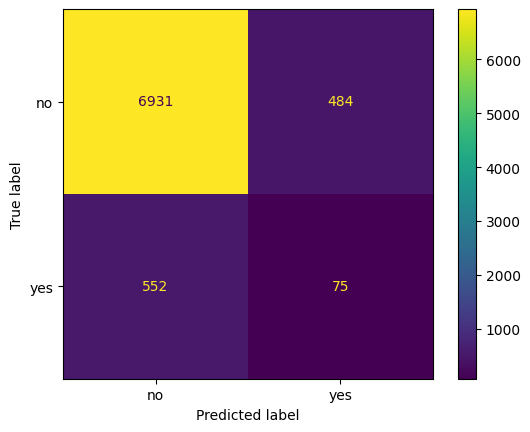

In [43]:
cm_test_oversampled_knn = confusion_matrix(y_test, y_test_pred_knn_over)

disp_test_over_knn = ConfusionMatrixDisplay(cm_test_oversampled_knn, display_labels=topmodel_knn_over.classes_)
disp_test_over_knn.plot()
plt.savefig('../Slides/conf_matrix_test_oversampled_knn.png', dpi=300, transparent=True)
plt.show()

In [44]:
print("The accuracy in the TRAIN set is: {:.3f}".format(accuracy_score(y_train_over, y_train_pred_knn_over)))
print("The accuracy in the TEST  set is: {:.3f}".format(accuracy_score(y_test, y_test_pred_knn_over)))
print(classification_report(y_test, y_test_pred_knn_over, target_names=['No','Yes']))
print(cohen_kappa_score(y_train_over, y_train_pred_knn_over))

The accuracy in the TRAIN set is: 1.000
The accuracy in the TEST  set is: 0.871
              precision    recall  f1-score   support

          No       0.93      0.93      0.93      7415
         Yes       0.13      0.12      0.13       627

    accuracy                           0.87      8042
   macro avg       0.53      0.53      0.53      8042
weighted avg       0.86      0.87      0.87      8042

1.0


In [46]:
knn_models_smoted = {}
weights = ["uniform","distance"]
p_values = [1,2,3]
scores_smoted = {}
for k in range(2,15):
    for weight in weights:
        for value in p_values:
            model_smoted = KNeighborsClassifier(n_neighbors=k,weights=weight,p=value).fit(X_train_SMOTE, y_train_SMOTE)
            print("Training the K-NN model with {} neighbours with weights {} and p set to {}...".format(k,weight,value))
            knn_models_smoted[str(k)+"_"+weight+"_"+str(value)] = model_smoted
            scores_smoted[str(k)+"_"+weight+"_"+str(value)] = model_smoted.score(X_test_transformed, y_test)
            print()

Training the K-NN model with 2 neighbours with weights uniform and p set to 1...

Training the K-NN model with 2 neighbours with weights uniform and p set to 2...

Training the K-NN model with 2 neighbours with weights uniform and p set to 3...

Training the K-NN model with 2 neighbours with weights distance and p set to 1...

Training the K-NN model with 2 neighbours with weights distance and p set to 2...

Training the K-NN model with 2 neighbours with weights distance and p set to 3...

Training the K-NN model with 3 neighbours with weights uniform and p set to 1...

Training the K-NN model with 3 neighbours with weights uniform and p set to 2...

Training the K-NN model with 3 neighbours with weights uniform and p set to 3...

Training the K-NN model with 3 neighbours with weights distance and p set to 1...

Training the K-NN model with 3 neighbours with weights distance and p set to 2...

Training the K-NN model with 3 neighbours with weights distance and p set to 3...

Training t

In [47]:
knn_models_smoted

{'2_uniform_1': KNeighborsClassifier(n_neighbors=2, p=1),
 '2_uniform_2': KNeighborsClassifier(n_neighbors=2),
 '2_uniform_3': KNeighborsClassifier(n_neighbors=2, p=3),
 '2_distance_1': KNeighborsClassifier(n_neighbors=2, p=1, weights='distance'),
 '2_distance_2': KNeighborsClassifier(n_neighbors=2, weights='distance'),
 '2_distance_3': KNeighborsClassifier(n_neighbors=2, p=3, weights='distance'),
 '3_uniform_1': KNeighborsClassifier(n_neighbors=3, p=1),
 '3_uniform_2': KNeighborsClassifier(n_neighbors=3),
 '3_uniform_3': KNeighborsClassifier(n_neighbors=3, p=3),
 '3_distance_1': KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'),
 '3_distance_2': KNeighborsClassifier(n_neighbors=3, weights='distance'),
 '3_distance_3': KNeighborsClassifier(n_neighbors=3, p=3, weights='distance'),
 '4_uniform_1': KNeighborsClassifier(n_neighbors=4, p=1),
 '4_uniform_2': KNeighborsClassifier(n_neighbors=4),
 '4_uniform_3': KNeighborsClassifier(n_neighbors=4, p=3),
 '4_distance_1': KNeighborsCl

In [48]:
knn_scores_smoted = {}

for key in knn_models_smoted.keys():
    knn_scores_smoted[key] = knn_models_smoted[key].score(X_test_transformed, y_test)

knn_scores_smoted

{'2_uniform_1': 0.8744093509077344,
 '2_uniform_2': 0.8361104202934594,
 '2_uniform_3': 0.7836359114648097,
 '2_distance_1': 0.8650833126088038,
 '2_distance_2': 0.8177070380502363,
 '2_distance_3': 0.7519273812484457,
 '3_uniform_1': 0.8270330763491669,
 '3_uniform_2': 0.7535438945535936,
 '3_uniform_3': 0.6734643123601094,
 '3_distance_1': 0.8311365332006964,
 '3_distance_2': 0.7610047251927381,
 '3_distance_3': 0.6851529470281025,
 '4_uniform_1': 0.8397164884357126,
 '4_uniform_2': 0.7735637901019646,
 '4_uniform_3': 0.7090276050733648,
 '4_distance_1': 0.8357373787615021,
 '4_distance_2': 0.76747077841333,
 '4_distance_3': 0.692738124844566,
 '5_uniform_1': 0.8011688634667993,
 '5_uniform_2': 0.7094006466053221,
 '5_uniform_3': 0.6299428002984332,
 '5_distance_1': 0.8088783884605819,
 '5_distance_2': 0.7243223078836111,
 '5_distance_3': 0.6499626958468043,
 '6_uniform_1': 0.8163392190997264,
 '6_uniform_2': 0.7276796816712261,
 '6_uniform_3': 0.6575478736632678,
 '6_distance_1': 0.

In [49]:
values = []
for key in list(scores_smoted.keys()):
    values.append((scores_smoted[key], int(key.split("_")[0]), key.split("_")[1], key.split("_")[2]))

knn_models_smoted_df = pd.DataFrame(values, columns=["score","K","weight","p"])
knn_models_smoted_df

,score,K,weight,p
0,0.874409,2,uniform,1
1,0.836110,2,uniform,2
2,0.783636,2,uniform,3
3,0.865083,2,distance,1
4,0.817707,2,distance,2
...,...,...,...,...
73,0.607436,14,uniform,2
74,0.528102,14,uniform,3
75,0.762746,14,distance,1
76,0.620741,14,distance,2


In [50]:
knn_models_smoted_df_csv = knn_models_smoted_df.to_csv('../Data/cleaned/knn_models_smoted.csv', index=False)

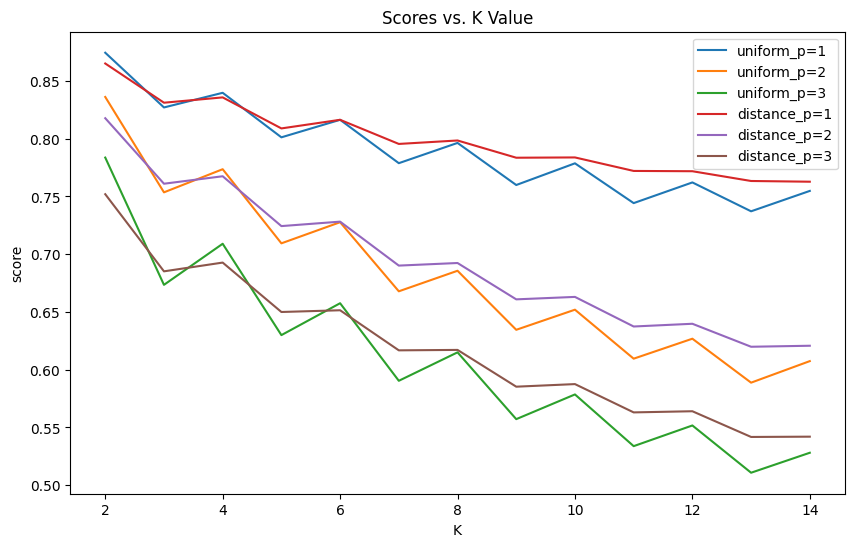

In [51]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=knn_models_smoted_df[(knn_models_smoted_df['weight']=="uniform") &
                                            (knn_models_smoted_df['p']=="1")],  x="K",y="score", 
                                             markers="x",label="uniform_p=1" ,ax = ax)

sns.lineplot(data=knn_models_smoted_df[(knn_models_smoted_df['weight']=="uniform") & 
                                            (knn_models_smoted_df['p']=="2") ], x="K",y="score",
                                             markers="o", label="uniform_p=2" ,ax = ax)

sns.lineplot(data=knn_models_smoted_df[(knn_models_smoted_df['weight']=="uniform") & 
                                            (knn_models_smoted_df['p']=="3") ], x="K",y="score",
                                             markers="o", label="uniform_p=3",ax = ax)

sns.lineplot(data=knn_models_smoted_df[(knn_models_smoted_df['weight']=="distance") & 
                                            (knn_models_smoted_df['p']=="1")],  x="K",y="score", 
                                             markers="x", label="distance_p=1" ,ax = ax)

sns.lineplot(data=knn_models_smoted_df[(knn_models_smoted_df['weight']=="distance") & 
                                            (knn_models_smoted_df['p']=="2") ], x="K",y="score",
                                             markers="o", label="distance_p=2",ax = ax)

sns.lineplot(data=knn_models_smoted_df[(knn_models_smoted_df['weight']=="distance") & 
                                            (knn_models_smoted_df['p']=="3") ], x="K",y="score",
                                             markers="o", label="distance_p=3",ax = ax)
plt.title('Scores vs. K Value')
plt.savefig('../Slides/scores_vs_kvalue_smoted.png', dpi=300, transparent=True)
plt.legend()
plt.show()

In [52]:
topmodel_knn_smote = KNeighborsClassifier(n_neighbors=2, weights = "uniform", p=1).fit(X_train_SMOTE, y_train_SMOTE)
topscore_smote = topmodel_knn_smote.score(X_test_transformed, y_test)

print("The score for the K-NN model with 2 neighbours, weighted by uniform is {:.3f}".format(topscore_smote))

with open('../Models/KNN_class_smoted.pkl', 'wb') as file:
    pickle.dump(topmodel_knn_smote, file)

The score for the K-NN model with 2 neighbours, weighted by uniform is 0.874


In [53]:
y_train_pred_knn_smote = topmodel_knn_smote.predict(X_train_SMOTE)
y_test_pred_knn_smote  = topmodel_knn_smote.predict(X_test_transformed)

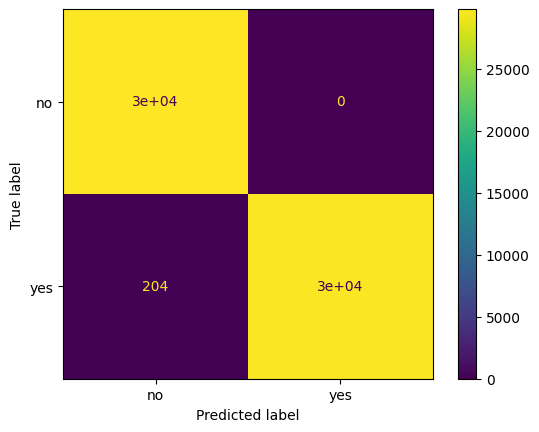

In [54]:
cm_train_smote_knn = confusion_matrix(y_train_over, y_train_pred_knn_smote)

disp_train_smote_knn = ConfusionMatrixDisplay(cm_train_smote_knn, display_labels=topmodel_knn_smote.classes_)
disp_train_smote_knn.plot()
plt.savefig('../Slides/conf_matrix_train_smoted_knn.png', dpi=300, transparent=True)
plt.show()

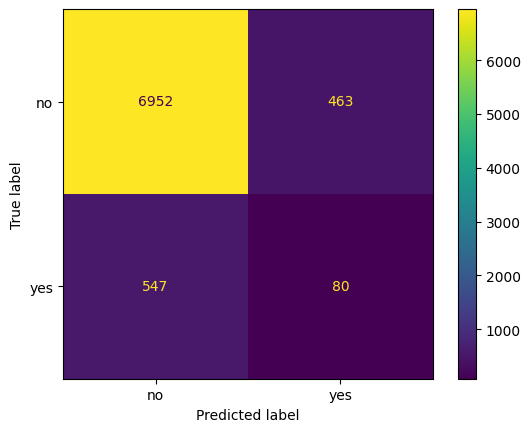

In [55]:
cm_test_smote_knn = confusion_matrix(y_test, y_test_pred_knn_smote)

disp_test_smote_knn = ConfusionMatrixDisplay(cm_test_smote_knn, display_labels=topmodel_knn_smote.classes_)
disp_test_smote_knn.plot()
plt.savefig('../Slides/conf_matrix_test_smoted_knn.png', dpi=300, transparent=True)
plt.show()

In [58]:
#print("The accuracy in the TRAIN set is: {:.3f}".format(accuracy_score(X_train_SMOTE, y_train_pred_knn_smote)))
print("The accuracy in the TEST  set is: {:.3f}".format(accuracy_score(y_test, y_test_pred_knn_smote)))
print(classification_report(y_test, y_test_pred_knn_over, target_names=['No','Yes']))
print(cohen_kappa_score(y_train_SMOTE, y_train_pred_knn_smote))

The accuracy in the TEST  set is: 0.874
              precision    recall  f1-score   support

          No       0.93      0.93      0.93      7415
         Yes       0.13      0.12      0.13       627

    accuracy                           0.87      8042
   macro avg       0.53      0.53      0.53      8042
weighted avg       0.86      0.87      0.87      8042

0.9931568883969005
